In [103]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils import resample
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "vscode" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [104]:
data = pd.read_csv('data/conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [82]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


#### Resample imbalenced classes ( V34 )

In [83]:
df_majority = data.loc[data['converted']==0]
df_minority = data.loc[data['converted']==1]

In [84]:
df_majority.shape, df_minority.shape

((275400, 6), (9180, 6))

In [85]:
df_majority = data.loc[data['converted']==0]
df_minority = data.loc[data['converted']==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=150000,    # to match majority class
                                 random_state=123) # reproducible results
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,     # sample with replacement
                                 n_samples=150000,    # to match majority class
                                 random_state=123) # reproducible results

In [86]:
# Combine majority class with upsampled minority class
data = pd.concat([df_majority_downsampled, df_minority_upsampled])

# Display new class counts
data['converted'].value_counts()

0    150000
1    150000
Name: converted, dtype: int64

### Train and Test sets for models

In [105]:
target_variable = 'converted'

X = data.drop(target_variable, axis=1)
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print('Target variable :', target_variable)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')
Target variable : converted



In [111]:
# Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



## Preprocessing

In [112]:
numeric_features = ['age', 'total_pages_visited']
categorical_features = ['new_user', 'country', 'source']

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['age', 'total_pages_visited']
Found categorical features  ['new_user', 'country', 'source']


In [113]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()), 
    ('scaler', StandardScaler()),
    #('polynomial', PolynomialFeatures())
])

# Create pipeline for categorical features
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [114]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) 
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! 
print('...Done.')
print(X_test[0:5,:])

Performing preprocessings on train set...
       country  age  new_user source  total_pages_visited
162123      US   20         1    Ads                    4
27065    China   29         1    Ads                    3
70329       US   36         0    Seo                    3
138712      US   23         1    Seo                    8
104858      UK   41         1    Ads                    3
...Done.
[[-1.27650481 -0.2618471   1.          0.          0.          1.
   0.          0.        ]
 [-0.18867057 -0.56090876  1.          0.          0.          0.
   0.          0.        ]
 [ 0.65742272 -0.56090876  0.          0.          0.          1.
   0.          1.        ]
 [-0.9138934   0.93439955  1.          0.          0.          1.
   0.          1.        ]
 [ 1.26177508 -0.56090876  1.          0.          1.          0.
   0.          0.        ]]

Performing preprocessings on test set...
       country  age  new_user  source  total_pages_visited
249036      US   32         1     

## Performance assessment 
- f1_score, cross_val_score, confusion matrices, Feature Importance and Classification report

In [115]:
def evaluate_performance(model):
  Y_train_pred = model.predict(X_train)
  Y_test_pred = model.predict(X_test)

  # Here, the f1-score will be used to assess the performances on the leaderboard
  print(model.__class__.__name__)
  print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
  print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
  print()
  
  scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='f1')
  print('The cross-validated f1 score is : ', scores.mean())
  print('The standard deviation is : ', scores.std())
  print('is this model overfitting ? ', f1_score(Y_test, Y_test_pred) - f1_score(Y_train, Y_train_pred) > scores.std())

  # Visualize confusion matrices
  _, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
  axes[0].set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, ax=axes[0]) # ConfusionMatrixDisplay from sklearn

  axes[1].set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
  ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, ax=axes[1]) # ConfusionMatrixDisplay from sklearn
  plt.show()

  # Feature Importance
  # numeric_features +  encoded categorical column names
  columns = np.append(numeric_features, preprocessor.transformers_[1][1]['encoder'].get_feature_names_out(categorical_features))
  try:
    coefs = pd.DataFrame(index=columns, data=model.coef_.transpose(), columns=['coefficients'] )
    # Compute abs() and sort values
    feature_importance = abs(coefs).sort_values(by = 'coefficients')
    # Plot coefficients
    fig = px.bar(feature_importance, orientation = 'h', title='Feature Importance')
    fig.update_layout(showlegend = False, 
                      margin = {'l': 120} # to avoid cropping of column names
                      )
    fig.show()
  except:
    pass

  # Classification report
  print('classification_report on Train set')
  print(classification_report(Y_train,Y_train_pred))
  print('---')
  print('classification_report on Test set')
  print(classification_report(Y_test,Y_test_pred))

In [116]:
def get_f1_score(model):
  Y_train_pred = model.predict(X_train)
  Y_test_pred = model.predict(X_test)

  # Here, the f1-score will be used to assess the performances on the leaderboard
  print(model.__class__.__name__)
  print("f1-score on train set : ", f1_score(Y_train, Y_train_pred))
  print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))

## Model

#### **Bagging**

##### XGBoost (with hyperparameter optimization)

In [122]:
# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested

# on commence grand
params1 = {
    'max_depth': [10, 100, 1000],
    'min_child_weight': [2, 20, 200],
    'n_estimators': [1, 10, 100]
}

# on a réduit à 
params2 = {
    # (V18)
    'max_depth': [13, 14, 15],
    'min_child_weight': [15, 20, 25],
    'n_estimators': [8, 10, 12]
}

params3 = {
    'max_depth': [2, 4, 8],
    'min_child_weight': [2, 4, 6],
    'n_estimators': [100, 1000]
}

params4 = {
    'max_depth': [7,8,9],
    'min_child_weight': [15, 20, 25],
    'n_estimators': [8, 10, 12]
}

params5 = {
    # (36)
    'max_depth': [13, 14, 15],
    'min_child_weight': [15, 20, 25],
    'n_estimators': [12, 14, 18]
}

print(params2)
xgboost_opt = GridSearchCV(xgboost, param_grid = params5, scoring='f1', cv = 3, verbose = 3) # cv : the number of folds to be used for CV
xgboost_opt.fit(X_train, Y_train)
print("...Done.")
print()
get_f1_score(xgboost_opt)

Grid search...
{'max_depth': [13, 14, 15], 'min_child_weight': [15, 20, 25], 'n_estimators': [8, 10, 12]}
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END max_depth=13, min_child_weight=15, n_estimators=12;, score=0.751 total time=   0.6s
[CV 2/3] END max_depth=13, min_child_weight=15, n_estimators=12;, score=0.764 total time=   0.6s
[CV 3/3] END max_depth=13, min_child_weight=15, n_estimators=12;, score=0.761 total time=   0.6s
[CV 1/3] END max_depth=13, min_child_weight=15, n_estimators=14;, score=0.754 total time=   0.7s
[CV 2/3] END max_depth=13, min_child_weight=15, n_estimators=14;, score=0.764 total time=   0.6s
[CV 3/3] END max_depth=13, min_child_weight=15, n_estimators=14;, score=0.760 total time=   0.7s
[CV 1/3] END max_depth=13, min_child_weight=15, n_estimators=18;, score=0.750 total time=   0.9s
[CV 2/3] END max_depth=13, min_child_weight=15, n_estimators=18;, score=0.766 total time=   0.9s
[CV 3/3] END max_depth=13, min_child_weight=15, n_estimat

In [123]:
print("Best hyperparameters : ", xgboost_opt.best_params_)
print("Best validation accuracy : ", xgboost_opt.best_score_)

Best hyperparameters :  {'max_depth': 15, 'min_child_weight': 25, 'n_estimators': 18}
Best validation accuracy :  0.7615454074535064


XGBClassifier
f1-score on train set :  0.768470693914215
f1-score on test set :  0.76580373269115

The cross-validated f1 score is :  0.7591885162461932
The standard deviation is :  0.006399139349645717
is this model overfitting ?  False


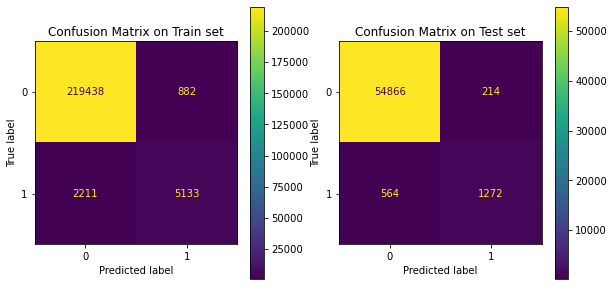

classification_report on Train set
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.85      0.70      0.77      7344

    accuracy                           0.99    227664
   macro avg       0.92      0.85      0.88    227664
weighted avg       0.99      0.99      0.99    227664

---
classification_report on Test set
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55080
           1       0.86      0.69      0.77      1836

    accuracy                           0.99     56916
   macro avg       0.92      0.84      0.88     56916
weighted avg       0.99      0.99      0.99     56916



In [124]:
evaluate_performance(xgboost_opt.best_estimator_)

## Submission

In [125]:
def retrain_and_submit(model, version=1):
  print(model)
  # Concatenate our train and test set to train your best classifier on all data with labels
  X = np.append(X_train,X_test,axis=0)
  Y = np.append(Y_train,Y_test)

  model.fit(X,Y)

  # Read data without labels
  data_without_labels = pd.read_csv('data/conversion_data_test.csv')
  print('Prediction set (without labels) :', data_without_labels.shape)

  # apply the preprocessing
  X_without_labels = preprocessor.transform(data_without_labels)
  data = {
    'converted': model.predict(X_without_labels)
  }

  Y_predictions = pd.DataFrame(columns=['converted'],data=data)
  Y_predictions.to_csv(f'submissions/conversion_data_test_predictions_Alexon_V{version}.csv', index=False)
  print('Done ....')

In [15]:
retrain_and_submit(xgboost_opt.best_estimator_, version=18)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=14, max_leaves=0, min_child_weight=20,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Prediction set (without labels) : (31620, 5)
Done ....


In [ ]:
pickle.dump(xgboost_opt.best_estimator_, open('models/xgboost_opt_v_18', 'wb'))

In [ ]:
retrain_and_submit(xgboost_opt.best_estimator_, version=32)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=6,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Prediction set (without labels) : (31620, 5)
Done ....


In [ ]:
retrain_and_submit(xgboost_opt.best_estimator_, version=33)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=13, max_leaves=0, min_child_weight=20,
              missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Prediction set (without labels) : (31620, 5)
Done ....


In [101]:
retrain_and_submit(xgboost_opt.best_estimator_, version=34)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=15,
              missing=nan, monotone_constraints='()', n_estimators=12, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Prediction set (without labels) : (31620, 5)
Done ....


In [121]:
# tran-test split random_state = 42
retrain_and_submit(xgboost_opt.best_estimator_, version=35)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=13, max_leaves=0, min_child_weight=20,
              missing=nan, monotone_constraints='()', n_estimators=12, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Prediction set (without labels) : (31620, 5)
Done ....


In [126]:
# tran-test split random_state = 42 et params = 5
retrain_and_submit(xgboost_opt.best_estimator_, version=36)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=15, max_leaves=0, min_child_weight=25,
              missing=nan, monotone_constraints='()', n_estimators=18, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)
Prediction set (without labels) : (31620, 5)
Done ....
